In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import random
from tqdm import tqdm
import os
import cv2
import pickle

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model


import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image
#import image

In [2]:
IMG_SIZE=224
img_arr = []
labels = []
label_encoder = LabelEncoder()

FLOWER_DAISY_DIR = "../input/flowers-recognition/flowers/daisy/"
FLOWER_DANDELION_DIR = "../input/flowers-recognition/flowers/dandelion/"
FLOWER_ROSE_DIR = "../input/flowers-recognition/flowers/rose/"
FLOWER_SUNFLOWER_DIR = "../input/flowers-recognition/flowers/sunflower/"
FLOWER_TULIP_DIR = "../input/flowers-recognition/flowers/tulip/"

In [3]:
# Creating funtion to assign labels to each flower
#image_cust = []
def feature_extraction(path, flower_type):
    
    label = str(flower_type)                # flower_type is nothing but the class label of the flower
    for img in tqdm(os.listdir(path)):      # os.listdir list all the files present in at the given location
        img_path = path + str(img)          # combining folder path and image files name
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       # Reading image file from the above location
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))        # Resizing image to dimensoion 224*224
        #image_cust.append(img)
        
        #img = np.expand_dims(img, axis=0)
        #img = preprocess_input(img)
        img_arr.append(img)       # Appending image value into a variable for further processing
        labels.append(label) 
        


In [4]:
def pre_process():
    # Following code will check for the presence of store image array and corresponding label in current working directory.
    # If both files are present in CWD then we'll directly load that file to avoide re-processing
    global img_arr
    global labels
    if os.path.isfile("img_arr_224.npy") and os.path.isfile("labels_224.npy"):
        print("Reading file....")
        img_arr = np.load("img_arr_224.npy")
        labels = np.load("labels_224.npy")
        print("Done...")

    else:

        # Creating list for storing image value and labels
        
        print("Pre-processing....")
        print("Flower -> Daisy....")
        feature_extraction(FLOWER_DAISY_DIR, "daisy")  # calling function to assign label to all images present at given dir location

        print("Flower -> Dandelion....")
        feature_extraction(FLOWER_DANDELION_DIR, "dandelion")

        print("Flower -> Rose....")
        feature_extraction(FLOWER_ROSE_DIR, "rose")

        print("Flower -> Sunflower....")
        feature_extraction(FLOWER_SUNFLOWER_DIR, "sunflower")

        print("Flower -> Tuplip....")
        feature_extraction(FLOWER_TULIP_DIR, "tulip")

                                                   # Saving image and label array in cwd
        img_arr = np.array(img_arr)
        labels = np.array(labels)

        
        labels = label_encoder.fit_transform(labels) # Encoding all the labels into 0s and 1s
        labels = to_categorical(labels,5)                 # As we are dealing with multiclass classification hear I'm performing onHotEncoding
        img_arr = np.array(img_arr)                    
        img_arr = img_arr/255                                # Normalizing image array

        pickle.dump(label_encoder, open("label_encoder.pkl", "wb"))
        np.save("img_arr_224.npy", img_arr)
        np.save("labels_224.npy", labels)

        print("Done...")


In [7]:
def fit_model(model):
    # Compiling the model
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    
    batch_size = 32
    epochs = 50


    # ReduceLROnPlateau -> Reduce learning rate when a metric has stopped improving.
    # monitor: quantity to be monitored.
    # factor: factor by which the learning rate will be reduced. new_lr = lr * factor.
    # patience: number of epochs with no improvement after which learning rate will be reduced.
    # verbose: int. 0: quiet, 1: update messages.
    # min_lr: lower bound on the learning rate.

    from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

    earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min', restore_best_weights=True)
    mcp_save = ModelCheckpoint('vgg16_model.h5', save_best_only=True, monitor='val_loss', mode='min')

    red_lr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor = 0.1, min_lr=0.001)
    
    
    
    # Fitting on training set and using validation set
    history = model.fit(X_train, y_train, batch_size = 128,
                        epochs = 50, 
                        validation_split = 0.2,
                        callbacks=[earlyStopping, mcp_save, red_lr],
                        verbose= 1)
    
    print("\n\n Model Evalation: \n")
    print(model.evaluate(X_test, y_test))
    return history

In [8]:
def get_predictions(model, img_arr):
    
    pred = [decode_predictions(model.predict(img_arr[i]), top = 3)[0] for i in tqdm(range(0,len(img_arr)))]
    
    return pred


In [9]:
def visualise_predictions(pred, img_arr):
    f, ax = plt.subplots(2, 4)
    f.set_size_inches(80, 40)
    
    for i in range(4):
        num = random.randint(0, len(image))
        ax[0,i].imshow(np.squeeze(img_arr[num]))
        b = sn.barplot(y=[c[1] for c in pred[num]], x=[c[2] for c in pred[num]], ax=ax[1, i])
        b.tick_params(labelsize=55)
        f.tight_layout()
            
    plt.show()

In [10]:
# Saving all preprocessed and splitted file on local disk so we don't have to perform again.
# Loading processed training and testing data from storage

if os.path.isfile("X_train.npy") and os.path.isfile("X_train.npy") and os.path.isfile("y_train.npy") and os.path.isfile("y_test.npy"):
    print("Loading training and testing data from storage...")
    label_encoder = pickle.load(open("label_encoder.pkl", "rb"))
    X_train = np.load("X_train.npy")
    X_test = np.load("X_test.npy")
    y_train = np.load("y_train.npy")
    y_test = np.load("y_test.npy")
    print("Done...")
else:
    pre_process()       # If preprocessed files are not present on disk then here I'm calling pre_process function to process image data
    print("Spliting data into training and test set.....")
    X_train, X_test, y_train, y_test = train_test_split(img_arr, labels, test_size=0.20, random_state=42)
    
    print("Saving train and test set")
    np.save("X_train.npy", X_train)
    np.save("X_test.npy", X_test)
    np.save("y_train.npy", y_train)
    np.save("y_test.npy", y_test)
    print("Done...")

Loading training and testing data from storage...
Done...


# Implementing VGG16

In [ ]:
_input = Input((224, 224, 3))
conv1 = Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu")(_input)
conv2 = Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu")(conv1)
pool1 = MaxPooling2D((2,2))(conv2)

conv3 = Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu")(pool1)
conv4 = Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu")(conv3)
pool2 = MaxPooling2D((2,2))(conv4)

conv5 = Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu")(pool2)
conv6 = Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu")(conv5)
conv7 = Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu")(conv6)
pool3 = MaxPooling2D((2,2))(conv7)

conv8 = Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu")(pool3)
conv9 = Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu")(conv8)
conv10 = Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu")(conv9)
pool4 = MaxPooling2D((2,2))(conv10)

conv11 = Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu")(pool4)
conv12 = Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu")(conv11)
conv13 = Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu")(conv12)
pool5 = MaxPooling2D((2,2))(conv13)

flat = Flatten()(pool5)
dense1 = Dense(4096, activation = "relu")(flat)
dense2 = Dense(4096, activation = "relu")(dense1)
dense3 = Dense(1000, activation = "relu")(dense2)
output = Dense(5, activation = "softmax")(dense3)

vgg16 = Model(inputs = _input, outputs = output)

In [ ]:
vgg16.summary()

# Pretrained VGG16

In [5]:
def load_VGG16():

    base_model = VGG16(
                weights="imagenet",
                include_top=False,
                input_shape=(224,224,3),
                pooling=None,
                classes=5,
                classifier_activation="softmax",
        )

    print("Pre-trained VGG16 model without top layers....\n")
    
    for layer in base_model.layers[:16]: # Setting trainable parameter to False of 16 layers of VGG16 pretrained model
        layer.trainable = False
    
    print(base_model.summary())
    print("\n\n*********************************************************\n")
    flatten_layer = layers.Flatten()
    dense_layer_1 = layers.Dense(50, activation='relu')
    dense_layer_2 = layers.Dense(20, activation='relu')
    prediction_layer = layers.Dense(5, activation='softmax')
    
    vgg16_model = models.Sequential([
            
            base_model,
            flatten_layer,
            dense_layer_1,
            dense_layer_2,
            prediction_layer])
    
    return vgg16_model

In [24]:
vgg16_model = load_VGG16()
vgg16_model.summary()

Pre-trained VGG16 model without top layers....

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (

In [25]:
history = fit_model(vgg16_model)

Epoch 1/50
22/22 [==============================] - 9s 367ms/step - loss: 1.5076 - accuracy: 0.3892 - val_loss: 1.0590 - val_accuracy: 0.5572
Epoch 2/50
22/22 [==============================] - 7s 306ms/step - loss: 0.7380 - accuracy: 0.7165 - val_loss: 0.7718 - val_accuracy: 0.7106
Epoch 3/50
22/22 [==============================] - 7s 308ms/step - loss: 0.5540 - accuracy: 0.7951 - val_loss: 0.5941 - val_accuracy: 0.7959
Epoch 4/50
22/22 [==============================] - 7s 314ms/step - loss: 0.4127 - accuracy: 0.8487 - val_loss: 0.5920 - val_accuracy: 0.8075
Epoch 5/50
22/22 [==============================] - 7s 310ms/step - loss: 0.3231 - accuracy: 0.8780 - val_loss: 0.5510 - val_accuracy: 0.7974
Epoch 6/50
22/22 [==============================] - 7s 309ms/step - loss: 0.2659 - accuracy: 0.9091 - val_loss: 0.4290 - val_accuracy: 0.8394
Epoch 7/50
22/22 [==============================] - 7s 313ms/step - loss: 0.1775 - accuracy: 0.9377 - val_loss: 0.5767 - val_accuracy: 0.8205
Epoch 

## We got accuracy of 85.76% using VGG16 pretrained model

In [26]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'])
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'])
    plt.show()

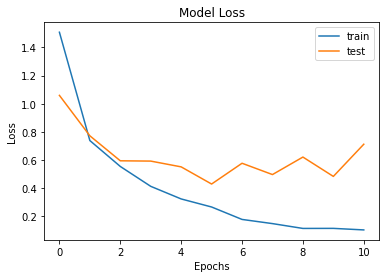

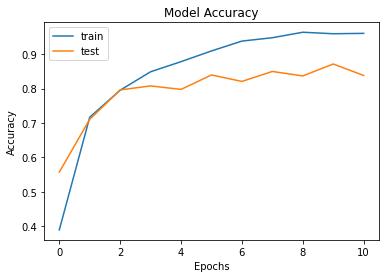

In [27]:
plot_loss_acc(history)

# VGG19

In [6]:
def load_VGG19():

    base_model = VGG19(
                weights="imagenet",
                include_top=False,
                input_shape=(224,224,3),
                pooling=None,
                classes=5,
                classifier_activation="softmax",
        )

    print("Pre-trained VGG19 model without top layers....\n")
    
    for layer in base_model.layers[:19]:
        layer.trainable = False
    
    print(base_model.summary())
    print("\n\n*********************************************************\n")
    flatten_layer = layers.Flatten()
    dense_layer_1 = layers.Dense(50, activation='relu')
    dense_layer_2 = layers.Dense(20, activation='relu')
    prediction_layer = layers.Dense(5, activation='softmax')
    
    vgg19_model = models.Sequential([
            
            base_model,
            flatten_layer,
            dense_layer_1,
            dense_layer_2,
            prediction_layer])
    
    
    return vgg19_model

In [28]:
vgg19_model = load_VGG19()
vgg19_model.summary()

Pre-trained VGG19 model without top layers....

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (

In [29]:
history = fit_model(vgg19_model)

Epoch 1/50
22/22 [==============================] - 10s 413ms/step - loss: 1.5667 - accuracy: 0.2951 - val_loss: 1.3219 - val_accuracy: 0.5152
Epoch 2/50
22/22 [==============================] - 8s 361ms/step - loss: 1.0465 - accuracy: 0.6162 - val_loss: 0.8285 - val_accuracy: 0.7236
Epoch 3/50
22/22 [==============================] - 8s 364ms/step - loss: 0.6809 - accuracy: 0.7773 - val_loss: 0.7833 - val_accuracy: 0.7525
Epoch 4/50
22/22 [==============================] - 8s 365ms/step - loss: 0.4765 - accuracy: 0.8345 - val_loss: 0.5041 - val_accuracy: 0.8090
Epoch 5/50
22/22 [==============================] - 8s 361ms/step - loss: 0.3309 - accuracy: 0.8860 - val_loss: 0.5068 - val_accuracy: 0.8509
Epoch 6/50
22/22 [==============================] - 8s 363ms/step - loss: 0.2871 - accuracy: 0.9030 - val_loss: 0.5190 - val_accuracy: 0.8336
Epoch 7/50
22/22 [==============================] - 8s 362ms/step - loss: 0.2153 - accuracy: 0.9301 - val_loss: 0.4853 - val_accuracy: 0.8495
Epoch

## We got accuracy of 84.61% using VGG19 pretrained model